In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("PySpark").getOrCreate()
spark

In [2]:
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.window import Window

In [96]:
def printdf(df, l=5):
    print(df.limit(l).toPandas())

def nullcount(df):
    print({col: df.filter(df[col].isNull()).count() for col in df.columns})

def shape(df):
    # df.toPandas().shape
    print((df.count(), len(df.columns)))

In [4]:
from pyspark.sql.types import StructType, StructField, IntegerType, DateType, StringType

schema = StructType([
    StructField("customer_id", IntegerType(), True),
    StructField("purchase_amount", IntegerType(), True),
    StructField("invoice_date", DateType(), True)])

In [40]:
data = spark.read.option("sep", "\t").csv("purchases.txt", header=False, schema=schema)
printdf(data)

,customer_id,purchase_amount,invoice_date
0,760,25,2009-11-06
1,860,50,2012-09-28
2,1200,100,2005-10-25
3,1420,50,2009-07-09
4,1940,70,2013-01-25


# Data Exploration

In [45]:
# data.toPandas().shape
shape(data)

(51243, 3)


In [80]:
# data.toPandas().isnull().sum()
nullcount(data)

{'customer_id': 0, 'purchase_amount': 63, 'invoice_date': 0}

In [81]:
# data.toPandas().describe()
# data.describe().show()
# data.printSchema()
# data.summary().show()

In [97]:
# Filter out null customer ids
clean_data = data.filter(F.col("purchase_amount").isNotNull())

shape(clean_data)
nullcount(clean_data)
clean_data.printSchema()

(51180, 3)
{'customer_id': 0, 'purchase_amount': 0, 'invoice_date': 0}
root
 |-- customer_id: integer (nullable = true)
 |-- purchase_amount: integer (nullable = true)
 |-- invoice_date: date (nullable = true)



In [86]:
# Explore the schema of the dataframe
# rtl_data.printSchema()

In [87]:
# See basic stats of numeric columns
clean_data.toPandas().describe()

,customer_id,purchase_amount
count,51180.000000,51180.000000
mean,108958.018367,62.131653
std,67640.623343,155.460745
min,10.000000,5.000000
25%,57750.000000,25.000000
50%,102500.000000,30.000000
75%,160545.000000,60.000000
max,264200.000000,4500.000000


In [89]:
# Max and Min Date

df = clean_data.toPandas()

print(df.invoice_date.min())
print(df.invoice_date.max())

2005-01-02
2015-12-31


# RFM Modeling

In [113]:
# Recency = Latest Date - Last Inovice Data 
# Frequency = count of invoice no. of transaction(s)
# Monetary = Sum of Total amount for each customer

import datetime as dt

# Set Latest date to 2015-12-31 as last invoice date was 2015-12-31. 
# This is to calculate the number of days from recent purchase
latest_date = F.to_date(F.lit("2015-12-31"), 'yyyy-MM-dd')

# Create RFM Modelling scores for each customer
rfm_scores = clean_data.groupBy("customer_id")\
    .agg((F.datediff(latest_date, F.max(F.col("invoice_date")))).alias("recency"),
         F.count(F.col("invoice_date")).alias("frequency"),
         F.sum(F.col("purchase_amount")).alias("monetary"))\
    .join(clean_data, "customer_id")


printdf(rfm_scores)

   customer_id  recency  frequency  monetary  purchase_amount invoice_date
0        78400     2644          3       100               40   2007-07-20
1        78400     2644          3       100               30   2008-10-04
2        78400     2644          3       100               30   2007-11-23
3       135000     1095          3       150               40   2011-12-28
4       135000     1095          3       150               60   2009-12-31


In [114]:
# rfm_scores.toPandas().describe()
shape(rfm_scores)

(51180, 6)


### Explore the RFM Scores using SNS

In [ ]:
# df_rfm_scores = rfm_scores.sample(False, 0.9, 41).toPandas()

In [ ]:
# type(df_rfm_scores)

In [115]:
rfm_scores_df = rfm_scores.toPandas()

<AxesSubplot:xlabel='monetary', ylabel='Count'>

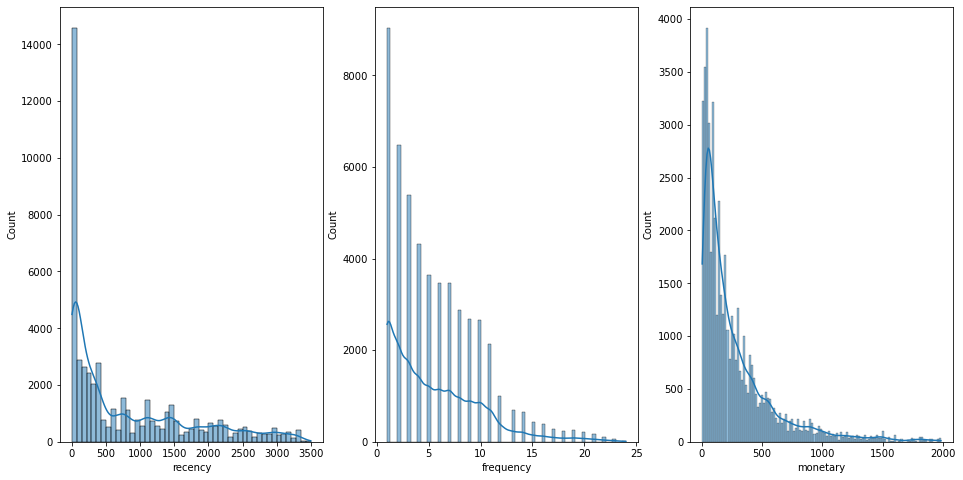

In [118]:
import seaborn as sns

fig, ax = plt.subplots(1, 3, figsize=(16, 8))

# Recency distribution plot
# sns.histplot(rfm_scores_df['recency'], kde=True, ax=ax[0])
sns.histplot(rfm_scores_df.query('recency < 3500')['recency'], kde=True, ax=ax[0])

# Frequency distribution plot
# sns.histplot(rfm_scores_df['frequency'], kde=True, ax=ax[1])
sns.histplot(rfm_scores_df.query('frequency < 25')['frequency'], kde=True, ax=ax[1])

# Monetary distribution plot
# sns.histplot(rfm_scores_df['monetary'], kde=True, ax=ax[2])
sns.histplot(rfm_scores_df.query('monetary < 2000')['monetary'], kde=True, ax=ax[2])

### Calculate RFM Scores

In [120]:
# We are going to divide our customer base into 3 segments: 
#    1st segment: top 30%
#    2nd segment: 30% - 60%
#    3rd segment: bottom 40%

# Understand and calculate different quantiles

# rfm_scores.toPandas()["Recency"].describe()
quantiles = rfm_scores.approxQuantile(
    ["recency", "frequency", "monetary"], 
    [0.33, 0.66], 
    0)
quantiles

[[89.0, 730.0], [2.0, 6.0], [85.0, 240.0]]

In [121]:
# Calculate R,F,M vavlues considering quantiles

rfm_scores = (rfm_scores
    .withColumn(
        "r",
        F.when(F.col("recency") < quantiles[0][0], F.lit(1))
         .when(F.col("recency") < quantiles[0][1], F.lit(2))
         .otherwise(F.lit(3)))
    .withColumn(
        "f",
        F.when(F.col("frequency") < quantiles[1][0], F.lit(3))
         .when(F.col("frequency") < quantiles[1][1], F.lit(2))
         .otherwise(F.lit(1)))
    .withColumn(
        "m",
        F.when(F.col("monetary") < quantiles[2][0], F.lit(3))
         .when(F.col("monetary") < quantiles[2][1], F.lit(2))
         .otherwise(F.lit(1))))

# printdf(rfm_scores.filter(F.col("CustomerID").isin([12346,12747,12748,12749,12820])))
# printdf(rfm_scores)

# rfm_scores.describe().show()

In [122]:
# Aggregate RFM scores

rfm_agg_scores = (rfm_scores
    .withColumn("rfm_score", F.col("r") + F.col("f") + F.col("m"))
    .withColumn("rfm_score_group", 
                F.concat(
                    F.col("r").cast(StringType()), 
                    F.col("f").cast(StringType()), 
                    F.col("m").cast(StringType())))
)


printdf(rfm_agg_scores)

   customer_id  recency  frequency  monetary  purchase_amount invoice_date  r  \
0        78400     2644          3       100               40   2007-07-20  3   
1        78400     2644          3       100               30   2008-10-04  3   
2        78400     2644          3       100               30   2007-11-23  3   
3       135000     1095          3       150               40   2011-12-28  3   
4       135000     1095          3       150               60   2009-12-31  3   

   f  m  rfm_score rfm_score_group  
0  2  2          7             322  
1  2  2          7             322  
2  2  2          7             322  
3  2  2          7             322  
4  2  2          7             322  


In [123]:
df_rfm_agg_scores = rfm_agg_scores.toPandas()
df_rfm_agg_scores.shape

(51180, 11)

<AxesSubplot:xlabel='rfm_score_group', ylabel='count'>

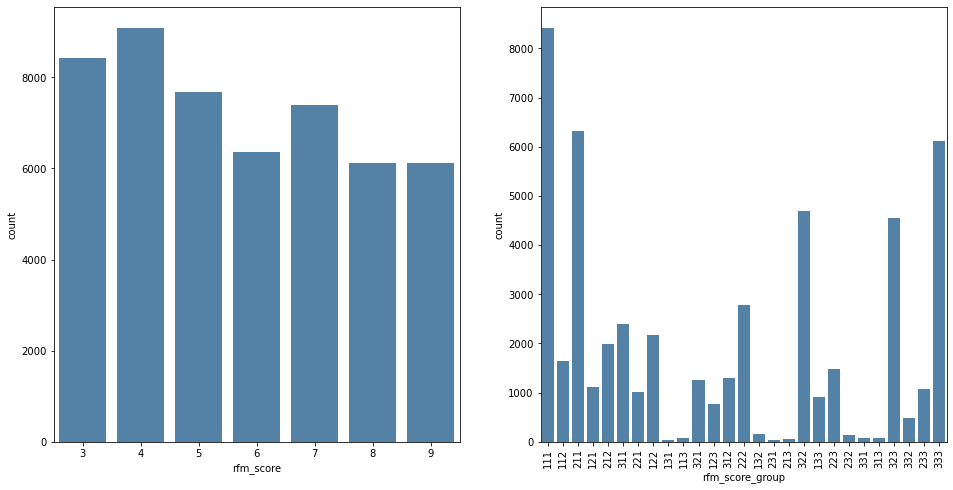

In [124]:
# Inspect RFM

df_rfm_agg_scores = df_rfm_agg_scores.sort_values(["rfm_score"])

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
plt.xticks(rotation=90)
# sns.histplot(df_rfm_agg_scores["RFMScore"], kde=True, bins=10, ax=ax[0])
sns.countplot(x="rfm_score", data=df_rfm_agg_scores, 
              color='steelblue', ax=ax[0])
sns.countplot(x="rfm_score_group", data=df_rfm_agg_scores, 
              color='steelblue', ax=ax[1])
# sns.histplot(df_rfm_agg_scores["RFMScoreGroup"], color='steelblue', ax=ax[2])

In [139]:
quantiles = rfm_agg_scores.approxQuantile("rfm_score", [0.3, 0.6], 0)
quantiles

[4.0, 6.0]

In [140]:
# Assign loyalty level to each customer

loyalty_level = ['Platinum', 'Gold', 'Silver']

rfm_loyalty = (rfm_agg_scores
    .withColumn(
        "loyalty",
        F.when((F.col("rfm_score") <= quantiles[0]), F.lit(loyalty_level[0]))
         .when((F.col("rfm_score") <= quantiles[1]), F.lit(loyalty_level[1]))
         .otherwise(F.lit(loyalty_level[2]))))


In [141]:
# printdf(rfm_loyalty.filter(F.col("CustomerID").isin([12346,12747,12748,12749,12820])))
# printdf(rfm_loyalty.filter(F.col("RFMScoreGroup") == "111"), 10)
# printdf(rfm_loyalty)

In [142]:
# rfm_loyalty

In [151]:
df_rfm_loyalty = rfm_loyalty.toPandas()
df_rfm_loyalty = df_rfm_loyalty.sort_values(["rfm_score"])
df_rfm_loyalty

,customer_id,recency,frequency,monetary,purchase_amount,invoice_date,r,f,m,rfm_score,rfm_score_group,loyalty
22830,17140,1,19,1150,80,2013-06-05,1,1,1,3,111,Platinum
15388,12230,47,11,400,30,2012-11-08,1,1,1,3,111,Platinum
15389,12230,47,11,400,30,2008-11-13,1,1,1,3,111,Platinum
15390,12230,47,11,400,50,2006-12-13,1,1,1,3,111,Platinum
15391,12230,47,11,400,40,2015-11-14,1,1,1,3,111,Platinum
...,...,...,...,...,...,...,...,...,...,...,...,...
30304,205630,803,1,45,45,2013-10-19,3,3,3,9,333,Silver
30305,196370,981,1,20,20,2013-04-24,3,3,3,9,333,Silver
30306,76330,3109,1,50,50,2007-06-27,3,3,3,9,333,Silver
30273,54280,3312,1,20,20,2006-12-06,3,3,3,9,333,Silver


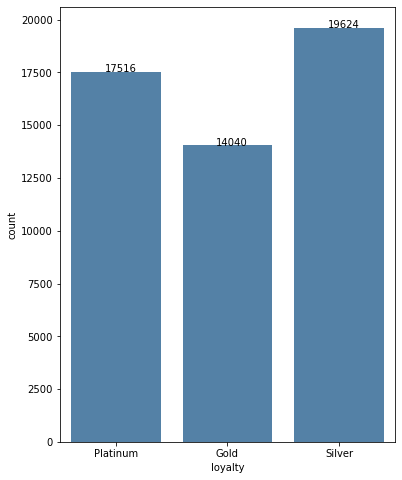

In [152]:
fig, ax = plt.subplots(1, 1, figsize=(6, 8))

# sns.histplot(df_rfm_loyalty["Loyalty"], color='steelblue', shrink=.8)
sns.countplot(x="loyalty", data=df_rfm_loyalty, color='steelblue')
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x() + 0.3, p.get_height() + 1))

# Visualize

In [146]:
# Restricting the dataset (Monetary < 5000 & Frequency < 500) to optimize the chart

df_rfm_loyalty = (rfm_loyalty
                  .filter(F.col("monetary") < 5000)
                  .filter(F.col("frequency") < 500)
#                   .filter(F.col("Loyalty") == "Platinum")
).toPandas()

<AxesSubplot:xlabel='monetary', ylabel='frequency'>

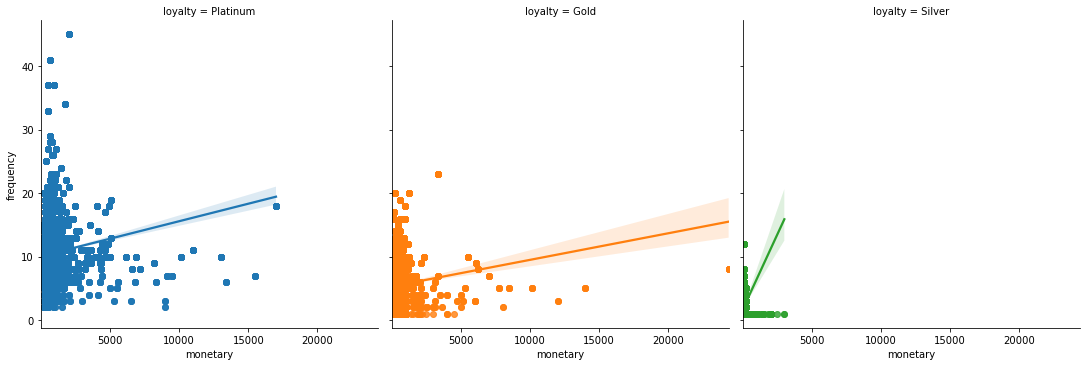

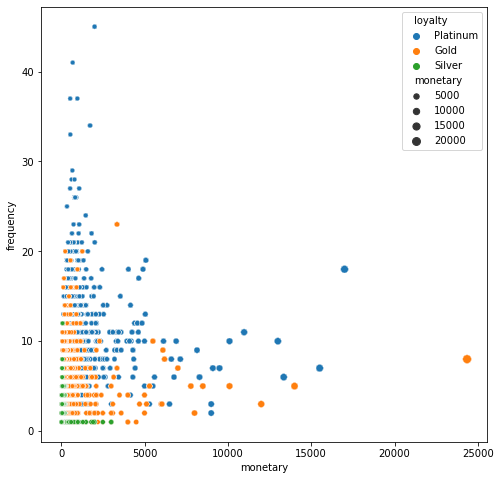

In [154]:
# Monetary vs Frequency for each segment
sns.lmplot(x='monetary', y='frequency', data=df_rfm_loyalty, col='loyalty', hue='loyalty', fit_reg=True)

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='monetary', y='frequency', data=df_rfm_loyalty, hue='loyalty', size='monetary')

<AxesSubplot:xlabel='recency', ylabel='monetary'>

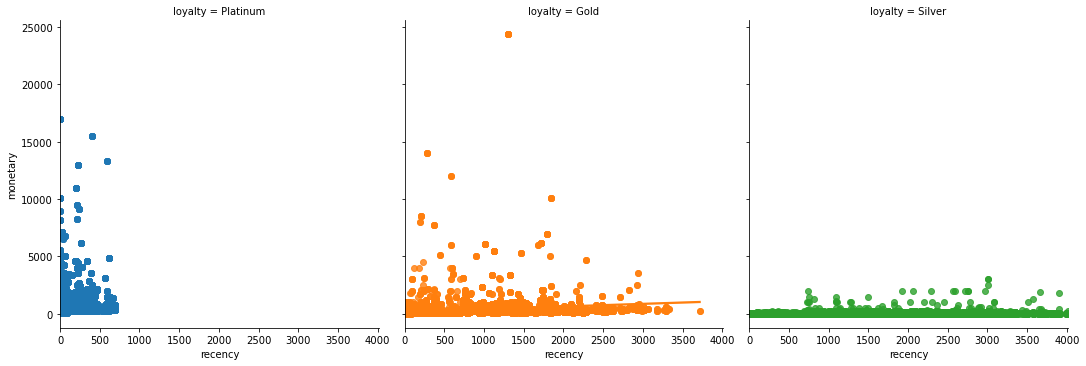

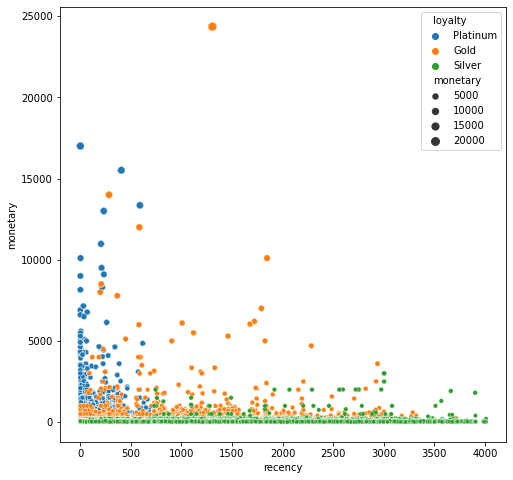

In [155]:
# Monetary vs Recency for each segment
sns.lmplot(x='recency', y='monetary', data=df_rfm_loyalty, col='loyalty', hue='loyalty', fit_reg=True)

# Monetary vs Recency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='recency', y='monetary', data=df_rfm_loyalty, hue='loyalty', size='monetary')

<AxesSubplot:xlabel='recency', ylabel='frequency'>

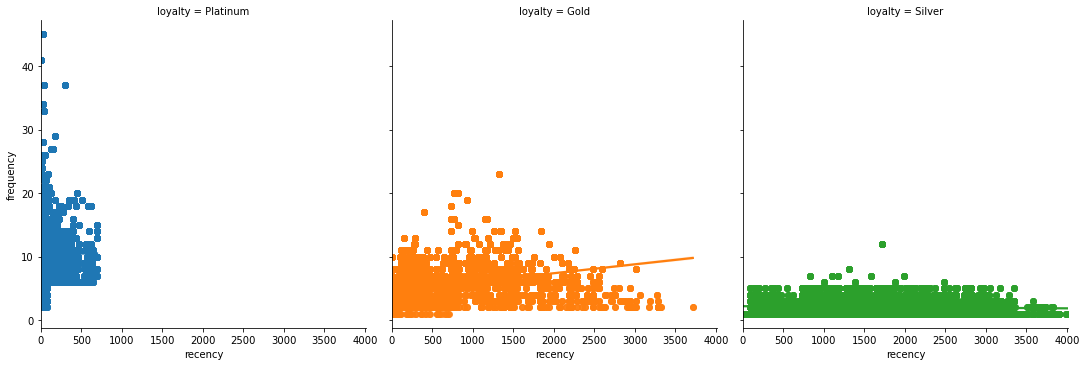

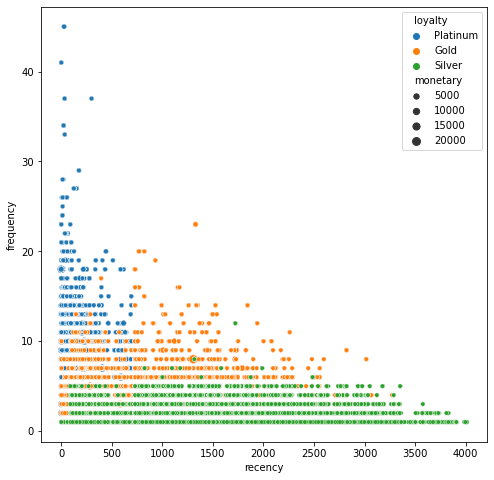

In [157]:
# Frequency vs Recency for each segment
sns.lmplot(x='recency', y='frequency', data=df_rfm_loyalty, col='loyalty', hue='loyalty', fit_reg=True)

# Monetary vs Recency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='recency', y='frequency', data=df_rfm_loyalty, hue='loyalty', size='monetary')

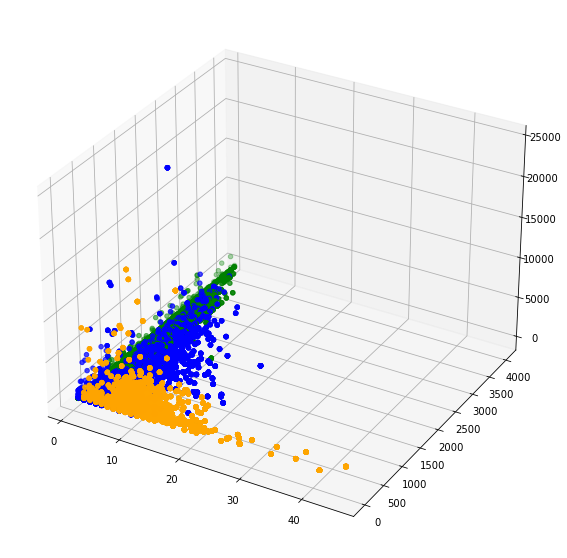

In [177]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

colors = {'Platinum':'orange', 'Gold':'blue', 'Silver':'green'}

ax.scatter(xs=df_rfm_loyalty.frequency, 
           ys=df_rfm_loyalty.recency, 
           zs=df_rfm_loyalty.monetary, 
           c=[colors[x] for x in df_rfm_loyalty.loyalty])